## Importing Required Libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
#from keras.applications.vgg19 import VGG19
from keras.models import Model

## Extracting Files

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -u "/content/gdrive/MyDrive/archive.zip" -d "/content"

In [ ]:
c = '/content/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/COVID-19_Radiography_Dataset/Normal/images'

In [ ]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 4000) # random select 4000 images for Normal

### Classes
* 0 -> Normal

* 1 -> COVID

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [ ]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,/content/COVID-19_Radiography_Dataset/COVID/im...,1
1,/content/COVID-19_Radiography_Dataset/COVID/im...,1
2,/content/COVID-19_Radiography_Dataset/COVID/im...,1
3,/content/COVID-19_Radiography_Dataset/COVID/im...,1
4,/content/COVID-19_Radiography_Dataset/COVID/im...,1


## Exploratory Data Analysis

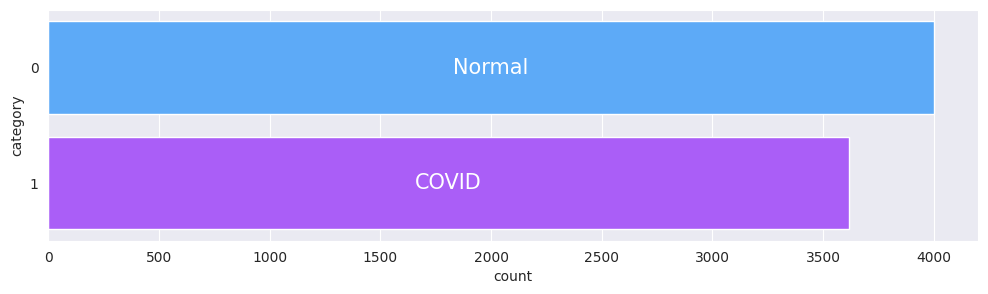

In [ ]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

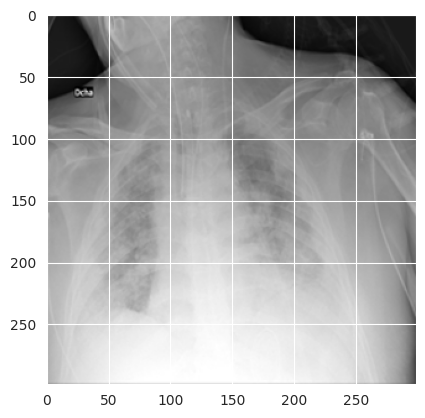

In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 6092 validated image filenames belonging to 2 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

test_generator = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 762 validated image filenames belonging to 2 classes.
Found 762 validated image filenames belonging to 2 classes.


## Model Training - ResNet50

#### Model Architecture

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
baseModel = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

94765736/94765736 [==============================] - 5s 0us/step


#### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

#### Optimizer - Adam

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint("best_model",
                                            save_best_only=True)
#stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
epochs = 200
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs, callbacks=[checkpoint])

Epoch 1/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5863 - accuracy: 0.6983 - val_loss: 0.5414 - val_accuracy: 0.7480
Epoch 2/200
407/407 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7063

407/407 [==============================] - 87s 215ms/step - loss: 0.5742 - accuracy: 0.7063 - val_loss: 0.5372 - val_accuracy: 0.7480
Epoch 3/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5772 - accuracy: 0.7019 - val_loss: 0.5486 - val_accuracy: 0.7257
Epoch 4/200
407/407 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7062

407/407 [==============================] - 89s 220ms/step - loss: 0.5802 - accuracy: 0.7062 - val_loss: 0.5361 - val_accuracy: 0.7480
Epoch 5/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5783 - accuracy: 0.6971 - val_loss: 0.5814 - val_accuracy: 0.6785
Epoch 6/200
407/407 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.7054

407/407 [==============================] - 88s 217ms/step - loss: 0.5746 - accuracy: 0.7054 - val_loss: 0.5325 - val_accuracy: 0.7520
Epoch 7/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5759 - accuracy: 0.7098 - val_loss: 0.5338 - val_accuracy: 0.7546
Epoch 8/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5742 - accuracy: 0.7070 - val_loss: 0.5542 - val_accuracy: 0.7415
Epoch 9/200
407/407 [==============================] - 70s 172ms/step - loss: 0.5806 - accuracy: 0.6947 - val_loss: 0.5737 - val_accuracy: 0.6969
Epoch 10/200
407/407 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7026

407/407 [==============================] - 88s 217ms/step - loss: 0.5718 - accuracy: 0.7026 - val_loss: 0.5200 - val_accuracy: 0.7533
Epoch 11/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5709 - accuracy: 0.7078 - val_loss: 0.5588 - val_accuracy: 0.7060
Epoch 12/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5742 - accuracy: 0.7060 - val_loss: 0.5357 - val_accuracy: 0.7428
Epoch 13/200
407/407 [==============================] - 70s 172ms/step - loss: 0.5686 - accuracy: 0.7057 - val_loss: 0.5225 - val_accuracy: 0.7612
Epoch 14/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5730 - accuracy: 0.7098 - val_loss: 0.5202 - val_accuracy: 0.7598
Epoch 15/200
407/407 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7173

407/407 [==============================] - 89s 218ms/step - loss: 0.5662 - accuracy: 0.7173 - val_loss: 0.5113 - val_accuracy: 0.7612
Epoch 16/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5666 - accuracy: 0.7177 - val_loss: 0.5306 - val_accuracy: 0.7454
Epoch 17/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5649 - accuracy: 0.7142 - val_loss: 0.5375 - val_accuracy: 0.7349
Epoch 18/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5644 - accuracy: 0.7142 - val_loss: 0.5338 - val_accuracy: 0.7625
Epoch 19/200
407/407 [==============================] - 70s 172ms/step - loss: 0.5671 - accuracy: 0.7104 - val_loss: 0.5332 - val_accuracy: 0.7349
Epoch 20/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5626 - accuracy: 0.7127 - val_loss: 0.5117 - val_accuracy: 0.7651
Epoch 21/200
407/407 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.7154

407/407 [==============================] - 88s 217ms/step - loss: 0.5596 - accuracy: 0.7154 - val_loss: 0.5092 - val_accuracy: 0.7625
Epoch 22/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5663 - accuracy: 0.7101 - val_loss: 0.5260 - val_accuracy: 0.7533
Epoch 23/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5634 - accuracy: 0.7167 - val_loss: 0.5135 - val_accuracy: 0.7638
Epoch 24/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5611 - accuracy: 0.7150 - val_loss: 0.5139 - val_accuracy: 0.7690
Epoch 25/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5579 - accuracy: 0.7221 - val_loss: 0.5161 - val_accuracy: 0.7559
Epoch 26/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5552 - accuracy: 0.7213 - val_loss: 0.5479 - val_accuracy: 0.7257
Epoch 27/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5668 - accuracy: 0.7182 - val_loss: 0.5184 - val_a

407/407 [==============================] - 89s 219ms/step - loss: 0.5620 - accuracy: 0.7129 - val_loss: 0.5043 - val_accuracy: 0.7638
Epoch 29/200
407/407 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.7208

407/407 [==============================] - 90s 221ms/step - loss: 0.5608 - accuracy: 0.7208 - val_loss: 0.5042 - val_accuracy: 0.7717
Epoch 30/200
407/407 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7124

407/407 [==============================] - 89s 218ms/step - loss: 0.5591 - accuracy: 0.7124 - val_loss: 0.5017 - val_accuracy: 0.7690
Epoch 31/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5647 - accuracy: 0.7198 - val_loss: 0.5033 - val_accuracy: 0.7717
Epoch 32/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5646 - accuracy: 0.7155 - val_loss: 0.5042 - val_accuracy: 0.7690
Epoch 33/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5532 - accuracy: 0.7221 - val_loss: 0.5045 - val_accuracy: 0.7743
Epoch 34/200
407/407 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7237

407/407 [==============================] - 89s 219ms/step - loss: 0.5518 - accuracy: 0.7237 - val_loss: 0.5011 - val_accuracy: 0.7703
Epoch 35/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5598 - accuracy: 0.7195 - val_loss: 0.5079 - val_accuracy: 0.7651
Epoch 36/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5568 - accuracy: 0.7267 - val_loss: 0.5531 - val_accuracy: 0.7165
Epoch 37/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5528 - accuracy: 0.7201 - val_loss: 0.5079 - val_accuracy: 0.7546
Epoch 38/200
407/407 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.7260

407/407 [==============================] - 89s 219ms/step - loss: 0.5479 - accuracy: 0.7260 - val_loss: 0.4986 - val_accuracy: 0.7690
Epoch 39/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5623 - accuracy: 0.7167 - val_loss: 0.5299 - val_accuracy: 0.7428
Epoch 40/200
407/407 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.7226

407/407 [==============================] - 90s 221ms/step - loss: 0.5549 - accuracy: 0.7226 - val_loss: 0.4928 - val_accuracy: 0.7703
Epoch 41/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5533 - accuracy: 0.7250 - val_loss: 0.5134 - val_accuracy: 0.7585
Epoch 42/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5698 - accuracy: 0.7147 - val_loss: 0.5450 - val_accuracy: 0.7218
Epoch 43/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5571 - accuracy: 0.7175 - val_loss: 0.5055 - val_accuracy: 0.7559
Epoch 44/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5609 - accuracy: 0.7172 - val_loss: 0.5114 - val_accuracy: 0.7625
Epoch 45/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5504 - accuracy: 0.7252 - val_loss: 0.5073 - val_accuracy: 0.7546
Epoch 46/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5544 - accuracy: 0.7211 - val_loss: 0.5000 - val_a

407/407 [==============================] - 91s 224ms/step - loss: 0.5506 - accuracy: 0.7259 - val_loss: 0.4921 - val_accuracy: 0.7743
Epoch 52/200
407/407 [==============================] - 71s 176ms/step - loss: 0.5483 - accuracy: 0.7221 - val_loss: 0.5106 - val_accuracy: 0.7651
Epoch 53/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5530 - accuracy: 0.7300 - val_loss: 0.4988 - val_accuracy: 0.7638
Epoch 54/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5377 - accuracy: 0.7318 - val_loss: 0.5208 - val_accuracy: 0.7520
Epoch 55/200
407/407 [==============================] - ETA: 0s - loss: 0.5429 - accuracy: 0.7287

407/407 [==============================] - 90s 222ms/step - loss: 0.5429 - accuracy: 0.7287 - val_loss: 0.4907 - val_accuracy: 0.7782
Epoch 56/200
407/407 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.7277

407/407 [==============================] - 89s 220ms/step - loss: 0.5434 - accuracy: 0.7277 - val_loss: 0.4884 - val_accuracy: 0.7769
Epoch 57/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5484 - accuracy: 0.7239 - val_loss: 0.4928 - val_accuracy: 0.7782
Epoch 58/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5466 - accuracy: 0.7260 - val_loss: 0.4925 - val_accuracy: 0.7730
Epoch 59/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5404 - accuracy: 0.7282 - val_loss: 0.5126 - val_accuracy: 0.7585
Epoch 60/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5480 - accuracy: 0.7301 - val_loss: 0.4959 - val_accuracy: 0.7717
Epoch 61/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5449 - accuracy: 0.7255 - val_loss: 0.5542 - val_accuracy: 0.7126
Epoch 62/200
407/407 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7269

407/407 [==============================] - 91s 224ms/step - loss: 0.5458 - accuracy: 0.7269 - val_loss: 0.4880 - val_accuracy: 0.7756
Epoch 63/200
407/407 [==============================] - 73s 179ms/step - loss: 0.5463 - accuracy: 0.7242 - val_loss: 0.4945 - val_accuracy: 0.7651
Epoch 64/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5444 - accuracy: 0.7301 - val_loss: 0.5142 - val_accuracy: 0.7585
Epoch 65/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5479 - accuracy: 0.7232 - val_loss: 0.5114 - val_accuracy: 0.7625
Epoch 66/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5498 - accuracy: 0.7226 - val_loss: 0.5710 - val_accuracy: 0.7021
Epoch 67/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5521 - accuracy: 0.7228 - val_loss: 0.4895 - val_accuracy: 0.7795
Epoch 68/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5484 - accuracy: 0.7214 - val_loss: 0.5441 - val_a

407/407 [==============================] - 90s 221ms/step - loss: 0.5553 - accuracy: 0.7221 - val_loss: 0.4849 - val_accuracy: 0.7756
Epoch 70/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5397 - accuracy: 0.7285 - val_loss: 0.5040 - val_accuracy: 0.7690
Epoch 71/200
407/407 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7367

407/407 [==============================] - 90s 222ms/step - loss: 0.5421 - accuracy: 0.7367 - val_loss: 0.4834 - val_accuracy: 0.7756
Epoch 72/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5421 - accuracy: 0.7303 - val_loss: 0.4870 - val_accuracy: 0.7782
Epoch 73/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5342 - accuracy: 0.7354 - val_loss: 0.4860 - val_accuracy: 0.7756
Epoch 74/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5425 - accuracy: 0.7329 - val_loss: 0.4920 - val_accuracy: 0.7743
Epoch 75/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5443 - accuracy: 0.7283 - val_loss: 0.4934 - val_accuracy: 0.7690
Epoch 76/200
407/407 [==============================] - 72s 178ms/step - loss: 0.5388 - accuracy: 0.7359 - val_loss: 0.5002 - val_accuracy: 0.7559
Epoch 77/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5483 - accuracy: 0.7288 - val_loss: 0.5158 - val_a

407/407 [==============================] - 91s 222ms/step - loss: 0.5323 - accuracy: 0.7339 - val_loss: 0.4830 - val_accuracy: 0.7743
Epoch 85/200
407/407 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7492

407/407 [==============================] - 91s 223ms/step - loss: 0.5238 - accuracy: 0.7492 - val_loss: 0.4827 - val_accuracy: 0.7769
Epoch 86/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5388 - accuracy: 0.7356 - val_loss: 0.5316 - val_accuracy: 0.7349
Epoch 87/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5342 - accuracy: 0.7318 - val_loss: 0.5825 - val_accuracy: 0.6601
Epoch 88/200
407/407 [==============================] - 72s 178ms/step - loss: 0.5386 - accuracy: 0.7301 - val_loss: 0.4887 - val_accuracy: 0.7546
Epoch 89/200
407/407 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.7305

407/407 [==============================] - 90s 222ms/step - loss: 0.5407 - accuracy: 0.7305 - val_loss: 0.4786 - val_accuracy: 0.7795
Epoch 90/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5353 - accuracy: 0.7328 - val_loss: 0.5002 - val_accuracy: 0.7703
Epoch 91/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5433 - accuracy: 0.7292 - val_loss: 0.5095 - val_accuracy: 0.7559
Epoch 92/200
407/407 [==============================] - 73s 178ms/step - loss: 0.5368 - accuracy: 0.7298 - val_loss: 0.4824 - val_accuracy: 0.7651
Epoch 93/200
407/407 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7387

407/407 [==============================] - 91s 224ms/step - loss: 0.5335 - accuracy: 0.7387 - val_loss: 0.4774 - val_accuracy: 0.7756
Epoch 94/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5422 - accuracy: 0.7285 - val_loss: 0.5164 - val_accuracy: 0.7559
Epoch 95/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5404 - accuracy: 0.7364 - val_loss: 0.4816 - val_accuracy: 0.7795
Epoch 96/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5444 - accuracy: 0.7278 - val_loss: 0.4917 - val_accuracy: 0.7703
Epoch 97/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5288 - accuracy: 0.7359 - val_loss: 0.4946 - val_accuracy: 0.7822
Epoch 98/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5341 - accuracy: 0.7418 - val_loss: 0.4997 - val_accuracy: 0.7638
Epoch 99/200
407/407 [==============================] - 72s 177ms/step - loss: 0.5346 - accuracy: 0.7336 - val_loss: 0.4868 - val_a

407/407 [==============================] - 89s 218ms/step - loss: 0.5313 - accuracy: 0.7365 - val_loss: 0.4669 - val_accuracy: 0.7795
Epoch 105/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5329 - accuracy: 0.7301 - val_loss: 0.4815 - val_accuracy: 0.7769
Epoch 106/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5378 - accuracy: 0.7356 - val_loss: 0.5045 - val_accuracy: 0.7612
Epoch 107/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5328 - accuracy: 0.7372 - val_loss: 0.5322 - val_accuracy: 0.7349
Epoch 108/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5324 - accuracy: 0.7319 - val_loss: 0.4904 - val_accuracy: 0.7664
Epoch 109/200
407/407 [==============================] - 71s 173ms/step - loss: 0.5315 - accuracy: 0.7438 - val_loss: 0.4932 - val_accuracy: 0.7651
Epoch 110/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5285 - accuracy: 0.7339 - val_loss: 0.4823 -

407/407 [==============================] - 88s 217ms/step - loss: 0.5280 - accuracy: 0.7370 - val_loss: 0.4658 - val_accuracy: 0.7782
Epoch 114/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5304 - accuracy: 0.7357 - val_loss: 0.4893 - val_accuracy: 0.7703
Epoch 115/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5213 - accuracy: 0.7426 - val_loss: 0.4674 - val_accuracy: 0.7782
Epoch 116/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5252 - accuracy: 0.7447 - val_loss: 0.4719 - val_accuracy: 0.7690
Epoch 117/200
407/407 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7336

407/407 [==============================] - 88s 216ms/step - loss: 0.5227 - accuracy: 0.7336 - val_loss: 0.4649 - val_accuracy: 0.7795
Epoch 118/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5226 - accuracy: 0.7365 - val_loss: 0.4736 - val_accuracy: 0.7743
Epoch 119/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5290 - accuracy: 0.7339 - val_loss: 0.4709 - val_accuracy: 0.7717
Epoch 120/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5213 - accuracy: 0.7385 - val_loss: 0.4815 - val_accuracy: 0.7730
Epoch 121/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5434 - accuracy: 0.7273 - val_loss: 0.5552 - val_accuracy: 0.7349
Epoch 122/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5726 - accuracy: 0.7259 - val_loss: 0.5282 - val_accuracy: 0.7795
Epoch 123/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5443 - accuracy: 0.7336 - val_loss: 0.5257 -

407/407 [==============================] - 89s 220ms/step - loss: 0.5336 - accuracy: 0.7346 - val_loss: 0.4590 - val_accuracy: 0.7808
Epoch 143/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5231 - accuracy: 0.7459 - val_loss: 0.4790 - val_accuracy: 0.7690
Epoch 144/200
407/407 [==============================] - 71s 175ms/step - loss: 0.5347 - accuracy: 0.7277 - val_loss: 0.4666 - val_accuracy: 0.7743
Epoch 145/200
407/407 [==============================] - 70s 173ms/step - loss: 0.5334 - accuracy: 0.7321 - val_loss: 0.4764 - val_accuracy: 0.7703
Epoch 146/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5319 - accuracy: 0.7365 - val_loss: 0.4877 - val_accuracy: 0.7730
Epoch 147/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5321 - accuracy: 0.7349 - val_loss: 0.5001 - val_accuracy: 0.7612
Epoch 148/200
407/407 [==============================] - 71s 174ms/step - loss: 0.5348 - accuracy: 0.7308 - val_loss: 0.4713 -

407/407 [==============================] - 92s 225ms/step - loss: 0.5208 - accuracy: 0.7472 - val_loss: 0.4562 - val_accuracy: 0.7808
Epoch 158/200
407/407 [==============================] - 72s 178ms/step - loss: 0.5303 - accuracy: 0.7356 - val_loss: 0.4724 - val_accuracy: 0.7703
Epoch 159/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5346 - accuracy: 0.7295 - val_loss: 0.4725 - val_accuracy: 0.7795
Epoch 160/200
407/407 [==============================] - 72s 176ms/step - loss: 0.5201 - accuracy: 0.7439 - val_loss: 0.4777 - val_accuracy: 0.7808
Epoch 161/200
407/407 [==============================] - 73s 179ms/step - loss: 0.5265 - accuracy: 0.7380 - val_loss: 0.4678 - val_accuracy: 0.7887
Epoch 162/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5322 - accuracy: 0.7292 - val_loss: 0.4582 - val_accuracy: 0.7769
Epoch 163/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5277 - accuracy: 0.7374 - val_loss: 0.4621 -

407/407 [==============================] - 92s 227ms/step - loss: 0.5272 - accuracy: 0.7360 - val_loss: 0.4533 - val_accuracy: 0.7822
Epoch 166/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5297 - accuracy: 0.7296 - val_loss: 0.4769 - val_accuracy: 0.7848
Epoch 167/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5244 - accuracy: 0.7423 - val_loss: 0.4605 - val_accuracy: 0.7822
Epoch 168/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5248 - accuracy: 0.7461 - val_loss: 0.4944 - val_accuracy: 0.7612
Epoch 169/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5262 - accuracy: 0.7406 - val_loss: 0.4670 - val_accuracy: 0.7756
Epoch 170/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5241 - accuracy: 0.7406 - val_loss: 0.4754 - val_accuracy: 0.7782
Epoch 171/200
407/407 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7406

407/407 [==============================] - 92s 226ms/step - loss: 0.5210 - accuracy: 0.7406 - val_loss: 0.4503 - val_accuracy: 0.7887
Epoch 172/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5217 - accuracy: 0.7392 - val_loss: 0.4506 - val_accuracy: 0.7927
Epoch 173/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5235 - accuracy: 0.7413 - val_loss: 0.4582 - val_accuracy: 0.7835
Epoch 174/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5227 - accuracy: 0.7467 - val_loss: 0.4748 - val_accuracy: 0.7848
Epoch 175/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5203 - accuracy: 0.7451 - val_loss: 0.4680 - val_accuracy: 0.7795
Epoch 176/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5165 - accuracy: 0.7424 - val_loss: 0.4648 - val_accuracy: 0.7756
Epoch 177/200
407/407 [==============================] - 75s 184ms/step - loss: 0.5275 - accuracy: 0.7315 - val_loss: 0.4509 -

407/407 [==============================] - 94s 230ms/step - loss: 0.5134 - accuracy: 0.7505 - val_loss: 0.4483 - val_accuracy: 0.7861
Epoch 179/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5184 - accuracy: 0.7452 - val_loss: 0.4566 - val_accuracy: 0.7887
Epoch 180/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5174 - accuracy: 0.7411 - val_loss: 0.5065 - val_accuracy: 0.7585
Epoch 181/200
407/407 [==============================] - 74s 182ms/step - loss: 0.5211 - accuracy: 0.7451 - val_loss: 0.4689 - val_accuracy: 0.7822
Epoch 182/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5236 - accuracy: 0.7387 - val_loss: 0.4543 - val_accuracy: 0.7900
Epoch 183/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5212 - accuracy: 0.7392 - val_loss: 0.5054 - val_accuracy: 0.7625
Epoch 184/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5215 - accuracy: 0.7452 - val_loss: 0.4663 -

407/407 [==============================] - 92s 226ms/step - loss: 0.5235 - accuracy: 0.7397 - val_loss: 0.4442 - val_accuracy: 0.7900
Epoch 186/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5215 - accuracy: 0.7388 - val_loss: 0.4778 - val_accuracy: 0.7717
Epoch 187/200
407/407 [==============================] - 74s 181ms/step - loss: 0.5310 - accuracy: 0.7352 - val_loss: 0.4473 - val_accuracy: 0.7874
Epoch 188/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5188 - accuracy: 0.7397 - val_loss: 0.4614 - val_accuracy: 0.7822
Epoch 189/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5264 - accuracy: 0.7420 - val_loss: 0.4715 - val_accuracy: 0.7625
Epoch 190/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5336 - accuracy: 0.7370 - val_loss: 0.4952 - val_accuracy: 0.7887
Epoch 191/200
407/407 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.7434

407/407 [==============================] - 92s 225ms/step - loss: 0.5175 - accuracy: 0.7434 - val_loss: 0.4430 - val_accuracy: 0.7927
Epoch 192/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5245 - accuracy: 0.7398 - val_loss: 0.4464 - val_accuracy: 0.7795
Epoch 193/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5181 - accuracy: 0.7433 - val_loss: 0.4449 - val_accuracy: 0.7913
Epoch 194/200
407/407 [==============================] - 73s 178ms/step - loss: 0.5306 - accuracy: 0.7267 - val_loss: 0.4615 - val_accuracy: 0.7769
Epoch 195/200
407/407 [==============================] - 73s 179ms/step - loss: 0.5166 - accuracy: 0.7443 - val_loss: 0.4530 - val_accuracy: 0.7927
Epoch 196/200
407/407 [==============================] - 73s 179ms/step - loss: 0.5149 - accuracy: 0.7431 - val_loss: 0.4476 - val_accuracy: 0.7808
Epoch 197/200
407/407 [==============================] - 73s 180ms/step - loss: 0.5244 - accuracy: 0.7365 - val_loss: 0.4468 -

## Saving Model

In [ ]:
model.save('/content/gdrive/MyDrive/ResNet50_11042023Sec.h5')

In [ ]:
#import shutil
%cp -av "/content/best_model" "/content/gdrive/MyDrive/ResNet50/"

'/content/best_model' -> '/content/gdrive/MyDrive/ResNet50/best_model'
'/content/best_model/variables' -> '/content/gdrive/MyDrive/ResNet50/best_model/variables'
'/content/best_model/variables/variables.index' -> '/content/gdrive/MyDrive/ResNet50/best_model/variables/variables.index'
'/content/best_model/variables/variables.data-00000-of-00001' -> '/content/gdrive/MyDrive/ResNet50/best_model/variables/variables.data-00000-of-00001'
'/content/best_model/assets' -> '/content/gdrive/MyDrive/ResNet50/best_model/assets'
'/content/best_model/saved_model.pb' -> '/content/gdrive/MyDrive/ResNet50/best_model/saved_model.pb'
'/content/best_model/keras_metadata.pb' -> '/content/gdrive/MyDrive/ResNet50/best_model/keras_metadata.pb'
'/content/best_model/fingerprint.pb' -> '/content/gdrive/MyDrive/ResNet50/best_model/fingerprint.pb'


## Model Evaluation


In [ ]:
model.evaluate(train_generator)
model.evaluate(valid_generator)


51/51 [==============================] - 3s 55ms/step - loss: 0.4676 - accuracy: 0.7861


[0.4676024317741394, 0.7860892415046692]

In [ ]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Model Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    
    plt.show()

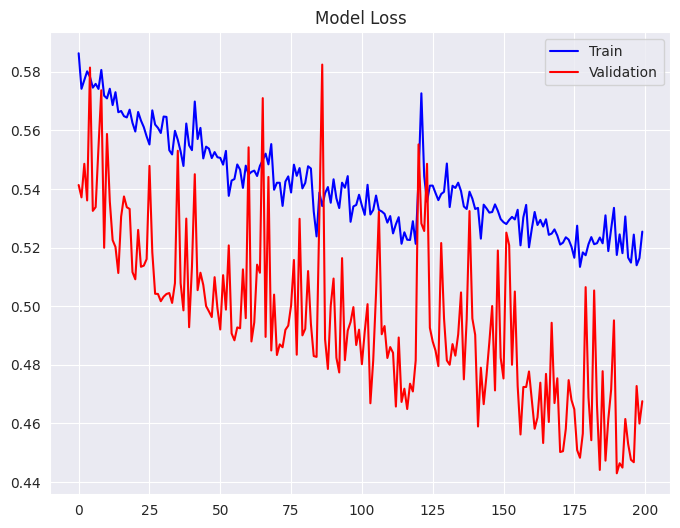

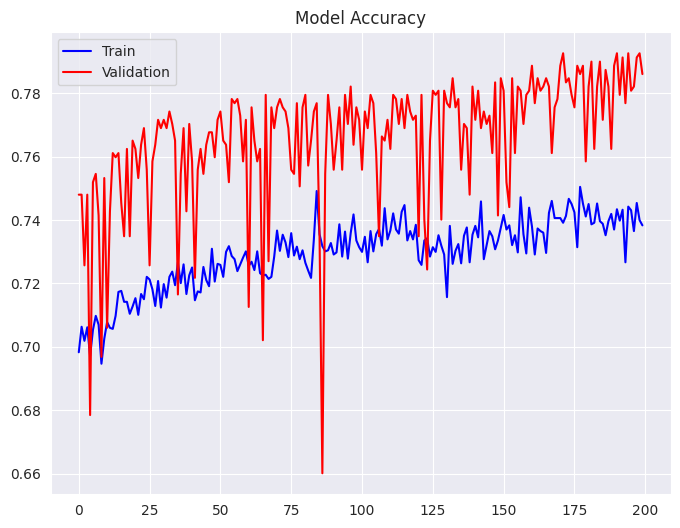

In [ ]:
plot_loss_acc(history)

## Classificaiton Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# predict classes of validation dataset
test_predict = model.predict(test_generator)

51/51 [==============================] - 4s 54ms/step


In [ ]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
labels = ['COVID', 'Normal']
report = classification_report(test_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.52      0.53      0.53       400
      Normal       0.47      0.46      0.46       362

    accuracy                           0.50       762
   macro avg       0.50      0.50      0.50       762
weighted avg       0.50      0.50      0.50       762



In [ ]:
cm = confusion_matrix(test_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

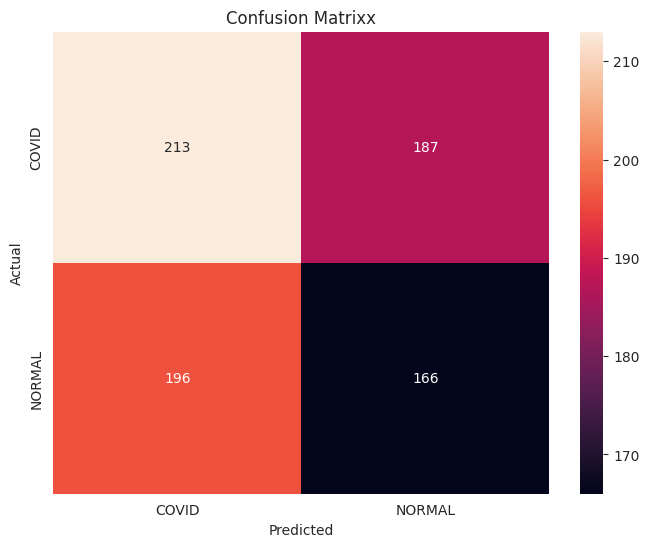

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
random.seed(42)
c2 = '/content/gdrive/MyDrive/dataset/COVID'
filenames2 = os.listdir(c2)

categories = []
for filename in filenames2:
    category = filename.split('-')[0]
    categories.append(str(1))


for i in range(len(filenames2)):
      filenames2[i] = os.path.join(c2, filenames2[i])
    
    
df2 = pd.DataFrame({
    'filename': filenames2,
    'category': categories
})

In [10]:
random.seed(42)
n2 = '/content/gdrive/MyDrive/dataset/Normal'
filenames3 = os.listdir(n2)

categories = []
for filename in filenames3:
    category = filename.split('-')[0]
    categories.append(str(0))


for i in range(len(filenames3)):
      filenames3[i] = os.path.join(n2, filenames3[i])
    
    
df3 = pd.DataFrame({
    'filename': filenames3,
    'category': categories
})

In [11]:
df2.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
1,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
2,/content/gdrive/MyDrive/dataset/COVID/covid-1.jpg,1
3,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
4,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1


In [12]:
df3.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/Normal/IM-0243...,0
1,/content/gdrive/MyDrive/dataset/Normal/IM-0235...,0
2,/content/gdrive/MyDrive/dataset/Normal/IM-0218...,0
3,/content/gdrive/MyDrive/dataset/Normal/IM-0234...,0
4,/content/gdrive/MyDrive/dataset/Normal/IM-0239...,0


In [13]:
frames = [df2, df3]

test2 = pd.concat(frames)

In [14]:
test2.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
1,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
2,/content/gdrive/MyDrive/dataset/COVID/covid-1.jpg,1
3,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
4,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1


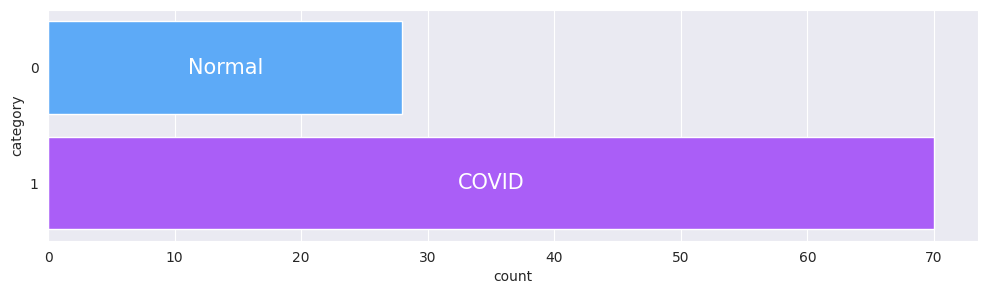

In [15]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = test2.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

In [16]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

test2_generator = valid_data_gen.flow_from_dataframe(
    test2, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 98 validated image filenames belonging to 2 classes.


## Classification Confusion Matrix

In [6]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ResNet50/ResNet50_11042023Sec.h5')

In [17]:
# predict classes of validation dataset
test_predict = model.predict(test2_generator)

7/7 [==============================] - 26s 3s/step


In [18]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [21]:
labels = ['COVID', 'Normal']
report = classification_report(test2_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.34      0.64      0.44        28
      Normal       0.78      0.50      0.61        70

    accuracy                           0.54        98
   macro avg       0.56      0.57      0.53        98
weighted avg       0.65      0.54      0.56        98



In [22]:
cm = confusion_matrix(test2_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

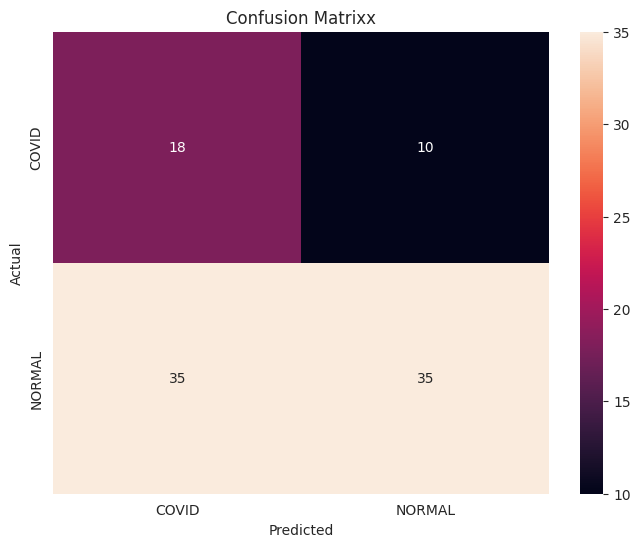

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()